In [24]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import lmdb
import imageio.v3 as iio
import io
import zipfile
import tarfile

def open_and_measure_data_modified(data_path, archive_type):
    heights = []
    widths = []
    num_images = 0

    folder_name = os.path.basename(data_path)
   
    if archive_type == 'lmdb':
        
        env_imgs = lmdb.open(data_path, readonly=True)

        with env_imgs.begin() as txn_imgs:
            cursor_imgs = txn_imgs.cursor()
            for img_key, img_value in cursor_imgs:
                img = Image.open(io.BytesIO(img_value))
                width, height = img.size
                num_images += 1
                if width < 400 and height < 400:
                    widths.append(width)
                    heights.append(height)

    elif archive_type == 'zip':
        # Handle a single ZIP file or all ZIP files in a folder
        if os.path.isdir(data_path):
            zip_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.lower().endswith('.zip')]
        else:
            zip_files = [data_path]

        for zip_file_path in zip_files:
            print(f"Processing {zip_file_path}...")
            try:
                with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
                    image_files = [name for name in zip_file.namelist() if name.lower().endswith(('.png', '.jpg', '.jpeg'))]
                    for img_file in image_files:
                        with zip_file.open(img_file) as img_data:
                            img = Image.open(img_data)
                            width, height = img.size
                            num_images += 1
                            if width < 400 and height < 400:
                                widths.append(width)
                                heights.append(height)
            except zipfile.BadZipFile:
                print(f"Error: {zip_file_path} is not a valid ZIP file.")
            except Exception as e:
                print(f"Error processing {zip_file_path}: {e}")

    elif archive_type == 'tar':
        
        with tarfile.open(data_path, 'r') as tar_file:
            image_files = [member for member in tar_file.getmembers() if member.name.lower().endswith(('.png', '.jpg', '.jpeg'))]
            for img_file in image_files:
                img_data = tar_file.extractfile(img_file)
                if img_data:
                    img = Image.open(img_data)
                    width, height = img.size
                    num_images += 1
                    if width < 400 and height < 400:
                        widths.append(width)
                        heights.append(height)
    else:
        raise ValueError("Unsupported archive type. Use 'zip' or 'tar'.")
    
    if widths and heights:
        height_stats = {
            'median': np.median(heights),
            'mean': np.mean(heights),
            'std': np.std(heights),
            'min': np.min(heights),
            'max': np.max(heights)
        }

        width_stats = {
            'median': np.median(widths),
            'mean': np.mean(widths),
            'std': np.std(widths),
            'min': np.min(widths),
            'max': np.max(widths)
        }
    else:
        print("No valid images found with dimensions below the threshold.")
        height_stats, width_stats = None, None
    
    plt.hist2d(widths, heights, bins=100)
    plt.colorbar()
    plt.xlabel('Width (in px)')
    plt.ylabel('Height (in px)')
    plt.title(f'{folder_name} Size Distribution (Log Scale) ({num_images} images)')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

    return height_stats, width_stats


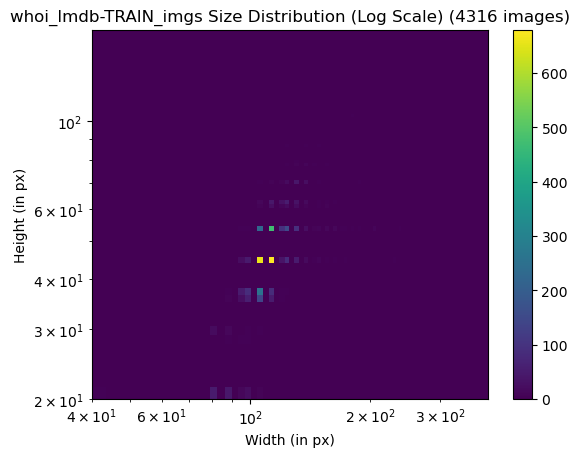

({'median': 45.0,
  'mean': 47.59116279069767,
  'std': 11.930801101643912,
  'min': 20,
  'max': 170},
 {'median': 113.0,
  'mean': 115.12651162790698,
  'std': 23.66060005173166,
  'min': 40,
  'max': 396})

In [33]:
data_dir_lmdb = '/home/hk-project-p0021769/hgf_diz2155/dataset/whoi_lmdb-TRAIN_imgs'
open_and_measure_data_modified(data_dir_lmdb, 'lmdb')


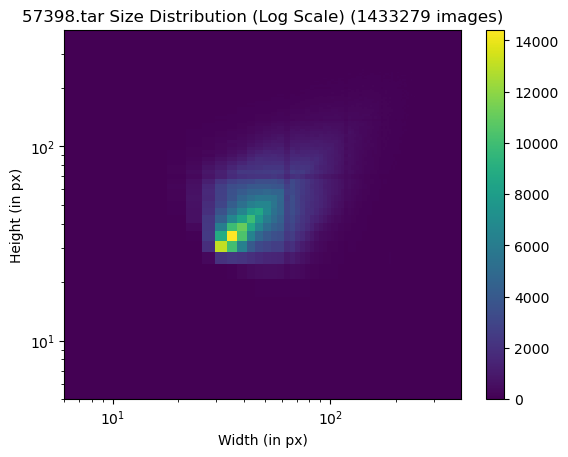

({'median': 68.0,
  'mean': 88.18197607242625,
  'std': 63.07795599559137,
  'min': 5,
  'max': 399},
 {'median': 67.0,
  'mean': 86.53361268336917,
  'std': 61.36857798194064,
  'min': 6,
  'max': 399})

In [ ]:
seanoe_zooscan_data = '/home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/57398.tar'
open_and_measure_data_modified(seanoe_zooscan_data, 'tar')


Processing /home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/seanoe_uvp/72973.zip...


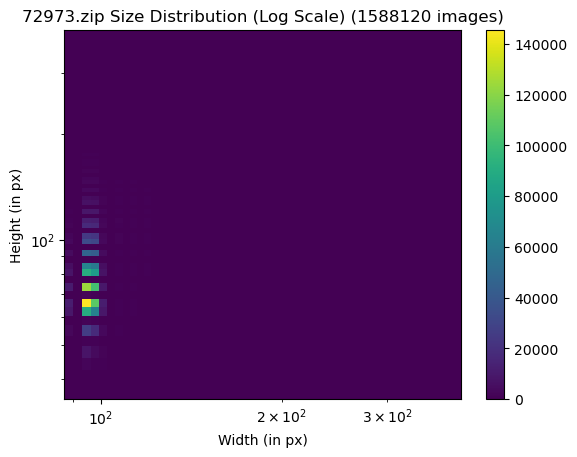

({'median': 79.0,
  'mean': 84.41069279393173,
  'std': 29.98533723341636,
  'min': 35,
  'max': 399},
 {'median': 97.0,
  'mean': 101.00801517067003,
  'std': 20.847765986535645,
  'min': 87,
  'max': 398})

In [25]:
seanoe_uvp = '/home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/seanoe_uvp/72973.zip'
open_and_measure_data_modified(seanoe_uvp, 'zip')

No valid images found with dimensions below the threshold.


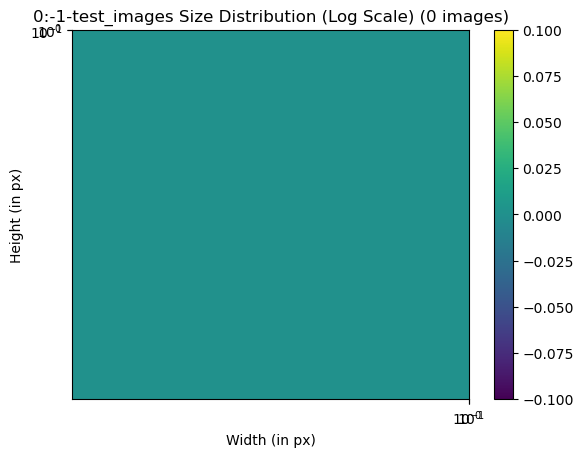

(None, None)

In [ ]:
# lmdb data of seanoe_uvp doesnt work
data = '/home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/seanoe_uvp_lmdb/0:-1-test_images'
open_and_measure_data_modified(data, 'lmdb')

Processing /home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/ifcb/IFCB1_2006_189_050524.zip...
Processing /home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/ifcb/IFCB1_2006_159_223627.zip...
Processing /home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/ifcb/IFCB1_2006_192_034916.zip...
Processing /home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/ifcb/IFCB1_2006_194_140505.zip...
Processing /home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/ifcb/IFCB1_2006_161_131359.zip...
Processing /home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/ifcb/IFCB1_2006_160_042421.zip...
Processing /home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/ifcb/IFCB1_2006_160_074000.zip...
Processing /home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/ifcb/IFCB1_2006_170_083434.zip...
Processing /home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/ifcb/IFCB1_2006_197_054703.zip...
Processing /home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/ifcb/IFCB1_2006_198_081925.zip...


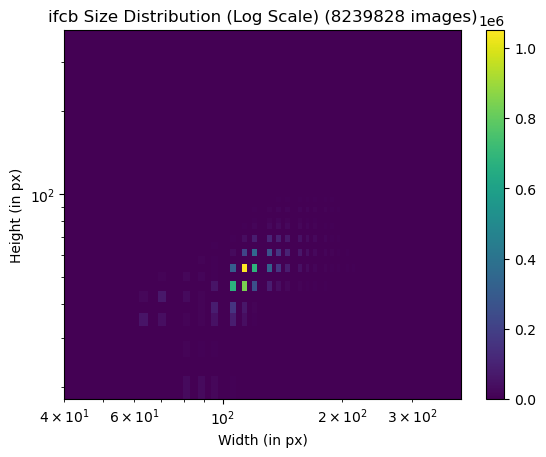

({'median': 53.0,
  'mean': 54.44082954325935,
  'std': 15.014748160541643,
  'min': 18,
  'max': 395},
 {'median': 114.0,
  'mean': 124.86513511289141,
  'std': 33.283563423651984,
  'min': 40,
  'max': 398})

In [26]:
ifcb_data = '/home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/ifcb'
open_and_measure_data_modified(ifcb_data, 'zip')


# printing one image

In [8]:
def print_one_image(lmdb_imgs_path):
    
    folder_name = lmdb_imgs_path.split('/')[-1]
    
    env_imgs = lmdb.open(lmdb_imgs_path, readonly=True)

    with env_imgs.begin() as txn_imgs:
        cursor_imgs = txn_imgs.cursor()
        
        for (img_key, img_value) in cursor_imgs:
            img = Image.open(io.BytesIO(img_value))
            
            # Display the image using matplotlib
            plt.imshow(img)
            plt.axis('off')  
            plt.title("Sample Image from LMDB")
            plt.show()


            break  # Stop after processing the first image

    return


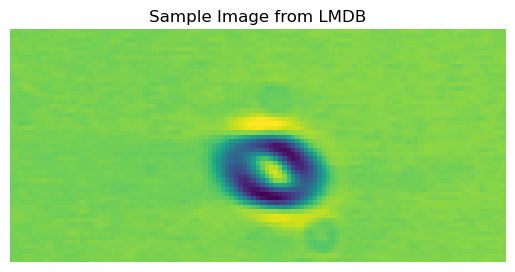

In [9]:
print_one_image(data_dir_lmdb)

Processing /home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/ifcb/D20240624T110352_IFCB127.zip...
Error: /home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/ifcb/D20240624T110352_IFCB127.zip is not a valid ZIP file.
No valid images found with dimensions below the threshold.


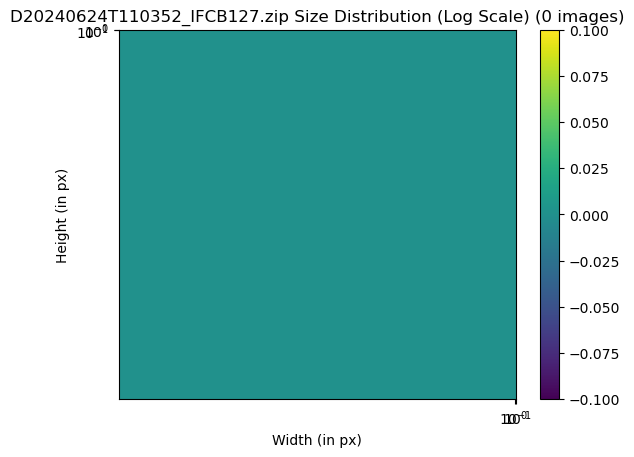

(None, None)

In [ ]:
#output case for a badzipfile
data = '/home/hk-project-p0021769/hgf_diz2155/dataset/raw_data/ifcb/D20240624T110352_IFCB127.zip'
open_and_measure_data_modified(data, 'zip')

